# Importing Libraries

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from collections import Counter
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')

# Useful user defined functions

In [27]:
# This function gives the percentage of null values in every column if null values exists 
# and also returns a list of columns which has null values

def null_value_check(train):
    missing = []

    for columns in train.columns:
        missing_count = train[train[columns] == -1][columns].count() #Counting the number of missing values in every column
        if missing_count > 0:
            missing.append(columns)
            missings_perc = missing_count*100/train.shape[0] #Finding the percentage of missing values in every column

            print('Variable %s has %i missing with %f percentage'%(columns, missing_count, missings_perc))

    print('\nIn total, there are {} variables with missing values'.format(len(missing)))
    return missing

In [28]:
# This function gives the number of outliers in the columns 
# and also returns the columns with outliers

def detect_outlier(df):
    features = df.columns
    outliers  = []
    for i, feature in enumerate(features):
        if df[feature].dtype == 'float64':
            # Calculate Q1 (25th percentile of the data) for the given feature
            Q1 = np.percentile(df[feature], 25)
            # Calculate Q3 (75th percentile of the data) for the given feature
            Q3 = np.percentile(df[feature], 75)
            # Use the interquartile range to calculate an outlier step
            step = 1.5 * (Q3 - Q1)
            feature_outliers = df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))]
            outliers.extend(list(feature_outliers.index.values))
            print('Feature: {}, outliers: {}\n'.format(feature, len(feature_outliers.index)))
    
    multi_feature_outliers = (Counter(outliers) - Counter(set(outliers))).keys()
    return multi_feature_outliers

In [29]:
# This function is used to handle imbalanced dataset. It upsamples the minority class and downsamples the majority classz

def up_and_down_sampling(df_train_temp,minority_class_percent):
    #Downsampling
    
    df_majority = df_train_temp[df_train_temp.target==0]
    df_minority = df_train_temp[df_train_temp.target==1]
    df_rows = df_train_temp.shape[0]
    n_samples=int(df_rows*((100 - minority_class_percent)/100))
    # Downsample majority class
    df_majority_undersampled = resample(df_majority, 
                                     replace=True,     # sample with replacement
                                     n_samples=n_samples,  # number of samples we want for majority variable
                                     random_state=123) # reproducible results

    # Combine minority class with Downsampled df
    df_undersampled = pd.concat([df_majority_undersampled, df_minority])

    # Display new class counts
    print("Target value counts after downsampling: \n" , df_undersampled.target.value_counts())
    

    #Upsampling

    df_majority = df_undersampled[df_undersampled.target==0]
    df_rows = df_train_temp.shape[0]
    n_samples=int(df_rows*(minority_class_percent/100))
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=n_samples, # number of samples we want for minority variable
                                     random_state=123) # reproducible results

    # Combine majority values with upsampled minority df
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Display new class counts
    print("\nTarget value counts after upsampling: \n" , df_upsampled.target.value_counts())
    
    
    return df_upsampled

# Loading the dataset from train.CSV file

In [30]:
train = pd.read_csv('train(1).csv')

# Data Summary

### 1.	Write at least 3 important inferences from the data above 

•	Target column is imbalanced

•	4 types of columns

•	Outliers

•	Null values

•	6 variables have too low variance.

In [31]:
print("• The dataset has " + str(train.shape[0]) + " rows and " + str(train.shape[1]) + " columns")

• The dataset has 595212 rows and 59 columns


## MetaData DataFrame for Reference

In [32]:
#Creating Metadata DataFrame so that it will be easy to handle and manipulate data during data exploration and analysing steps

#role: input, ID, target
#level: nominal, interval, ordinal, binary
#keep: True or False
#dtype: int, float, str

MetaData = pd.DataFrame(columns=['variable','role', 'level', 'keep', 'dtype'])
data =[]
for columns in train.columns:
    
    #Defining Role
    
    if columns == 'id':
        role = 'id'
    elif columns == 'target':
        role = 'target'
    else:
        role = 'input'
        
    #Defining DataTypes
    
    dtype = train[columns].dtype
    
    #Defining keep
    
    keep = True
    
    #Defining Level
    
    if columns[-3:] == 'bin' or columns == 'target':
        level = 'binary'
    elif columns[-3:] == 'cat' or columns == 'id':
        level = 'categorical' 
    elif train[columns].dtype == float:
        level = 'interval'
    elif train[columns].dtype == np.int64:
        level = 'ordinal'
        
        
    f_dict = {
        'variable' : columns,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    
    data.append(f_dict)

MetaData = MetaData.append(data)

### 2.	Is the data balanced? Meaning are targets 0 and 1 in the right proportion? 

target
0    573518
1     21694
Name: target, dtype: int64

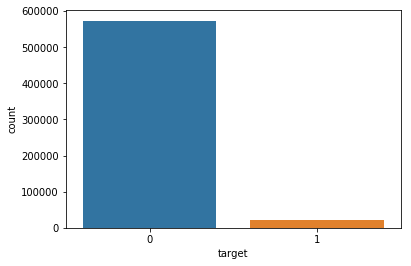

In [33]:
#Count of target variable.

sns.countplot(train.target)
train.groupby('target')['target'].count()

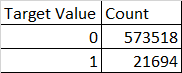

Data is highly imbalance with only ~3% of data belongs to minority (which is 1 in target) class. Need to do upscaling/down sampling after train-test split of data to get the desired results


In [34]:
#Checking the Distribution of variables across levels

MetaData.groupby('level')[['variable']].count()

,variable
level,
binary,18
categorical,15
interval,10
ordinal,16


### 3.	How many categorical features are there? 

15 Categorical features are there.

### 4.	How many binary features are there? 

18 Binary features are there.

## Null Values

In [35]:
missing = null_value_check(train)

Variable ps_ind_02_cat has 216 missing with 0.036290 percentage
Variable ps_ind_04_cat has 83 missing with 0.013945 percentage
Variable ps_ind_05_cat has 5809 missing with 0.975955 percentage
Variable ps_reg_03 has 107772 missing with 18.106490 percentage
Variable ps_car_01_cat has 107 missing with 0.017977 percentage
Variable ps_car_03_cat has 411231 missing with 69.089837 percentage
Variable ps_car_05_cat has 266551 missing with 44.782531 percentage
Variable ps_car_07_cat has 11489 missing with 1.930237 percentage
Variable ps_car_09_cat has 569 missing with 0.095596 percentage
Variable ps_car_11 has 5 missing with 0.000840 percentage
Variable ps_car_12 has 1 missing with 0.000168 percentage
Variable ps_car_14 has 42620 missing with 7.160474 percentage

In total, there are 12 variables with missing values


### 11.	Which are the top two features in terms of missing values? 

ps_car_03_cat, ps_car_05_cat have high percentage of missing values.

### 12.	In total, how many features have missing values? 

In total, there are 12 variables with missing values

In [36]:
MetaData.loc[MetaData['variable'] == 'ps_car_03_cat', 'keep'] = False
MetaData.loc[MetaData['variable'] == 'ps_car_05_cat', 'keep'] = False

In [37]:
#Removing variables that has high missing value count i.e ps_car_03_cat and ps_car_05_cat

train1 = train.drop(['ps_car_03_cat', 'ps_car_05_cat'], axis = 1)

In [38]:
vars_to_drop = ['ps_car_03_cat', 'ps_car_05_cat']

# Imputing with the mean for non categorical variables

mean_imp = SimpleImputer(missing_values=-1, strategy='mean')
mode_imp = SimpleImputer(missing_values=-1, strategy='most_frequent')
train1['ps_reg_03'] = mean_imp.fit_transform(train1[['ps_reg_03']]).ravel()
train1['ps_car_12'] = mode_imp.fit_transform(train1[['ps_car_12']]).ravel()
train1['ps_car_14'] = mean_imp.fit_transform(train1[['ps_car_14']]).ravel()
train1['ps_car_11'] = mode_imp.fit_transform(train1[['ps_car_11']]).ravel()

#Imputing missing values in categorical variables by their Mode

filtered_missing = [ i for i in missing if not i in vars_to_drop]

for columns in filtered_missing:
    train1.loc[train1[columns] == -1, columns] = train1[columns].mode()[0]

### 13.	What steps should be taken to handle the missing data? 

We can remove variable ps_car_03_cat, ps_car_05_cat as they have high percentage of missing values. For other variables, we can do missing value treatment by substituting mean and mode.
Missing values in Categorical variables can be replaced by the mode value in that variable.

In [39]:
#Checking missing values in the data, if any.
null_value_check(train1)


In total, there are 0 variables with missing values


[]

In [40]:
print("Shape of before null values check: ", train.shape)
print('\nShape of after null values check: ', train1.shape)

Shape of before null values check:  (595212, 59)

Shape of after null values check:  (595212, 57)


## Correlation

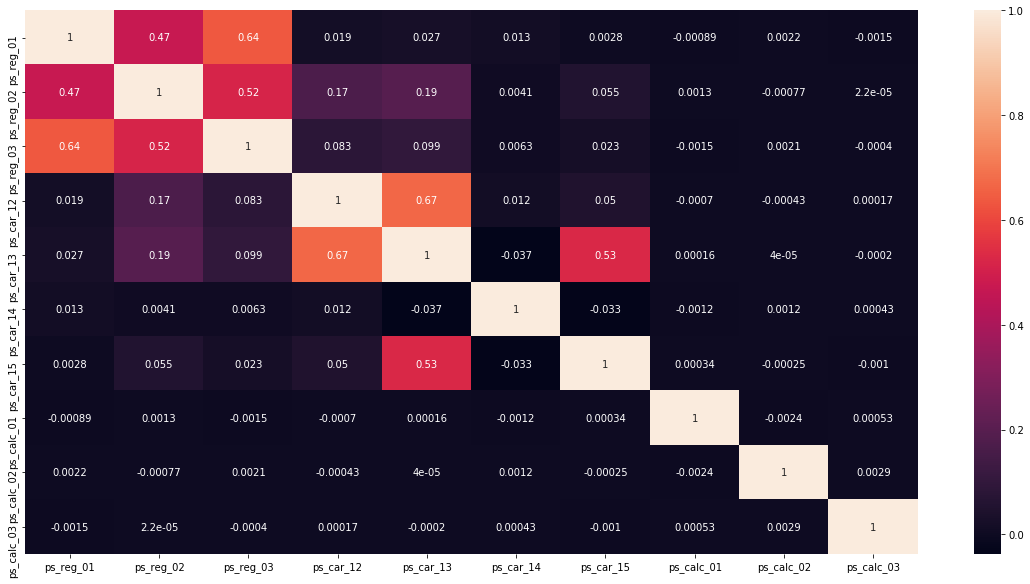

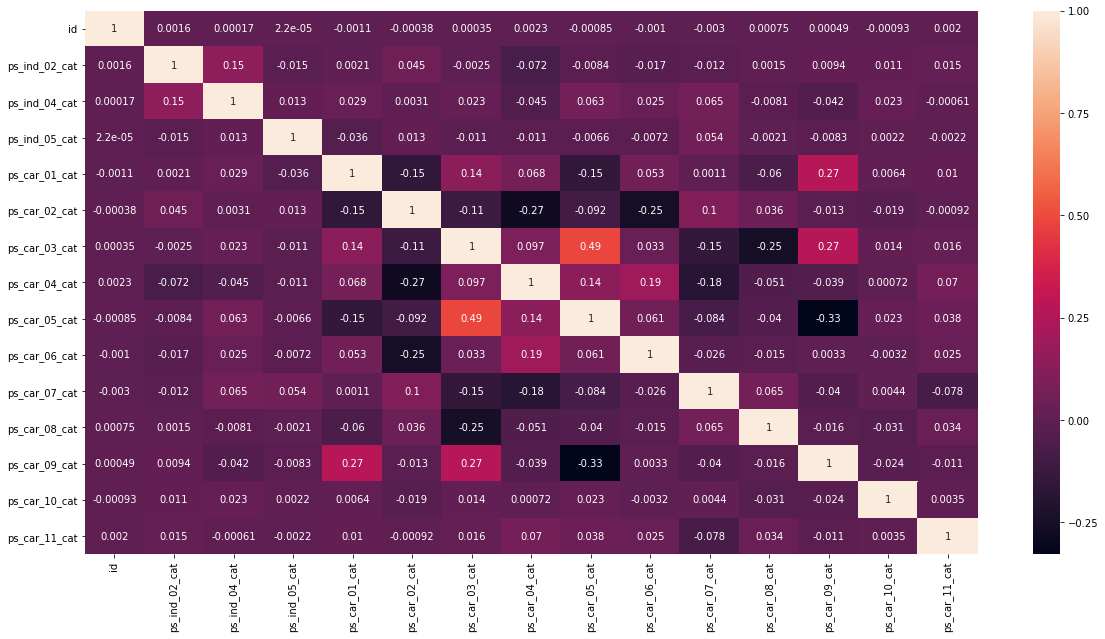

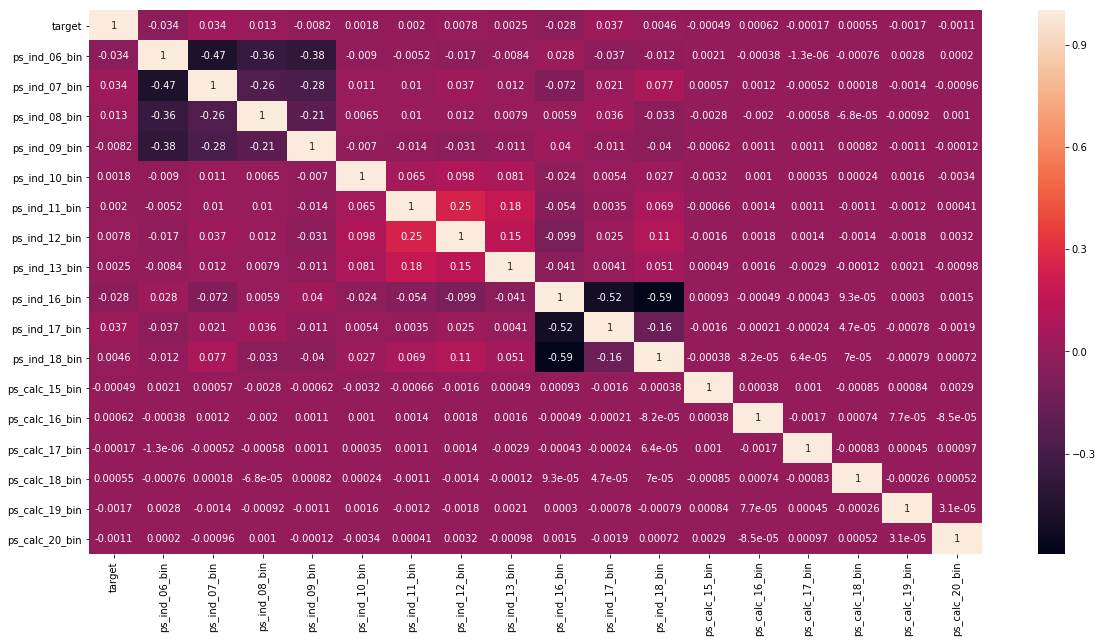

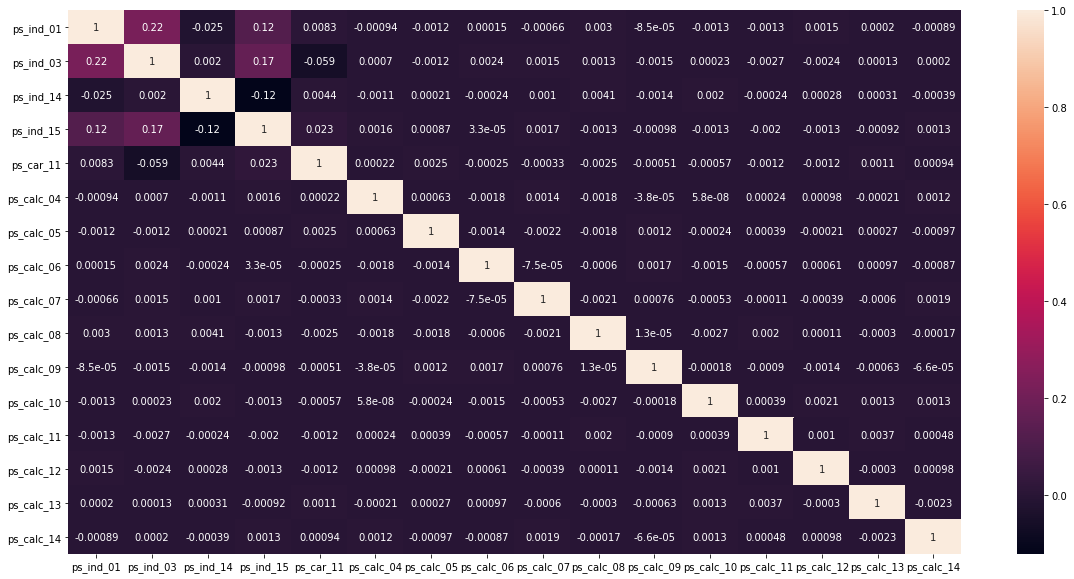

In [41]:
#Correlation between different types of variables
#Creating list of interval, categorical, binary and ordinal variables

for variable in MetaData.variable:
    IntervalVar = MetaData[MetaData.level=='interval']['variable']
    CategoricalVar = MetaData[MetaData.level=='categorical']['variable']
    BinaryVar = MetaData[MetaData.level=='binary']['variable']
    OrdinalVar = MetaData[MetaData.level=='ordinal']['variable']
    
all_variables = [IntervalVar, CategoricalVar, BinaryVar, OrdinalVar]

for x in all_variables:
    fig, ax = plt.subplots(figsize=(20,10))
    sns.heatmap(train[x].corr(), annot=True)

### 14.	Which interval variables have strong correlation? 

Interval Variables: We can see the following variables are highly correlated 
ps_reg_01
ps_reg_02
ps_reg_03
ps_reg_12
ps_reg_13
ps_reg_15

### 15.	What's the level of correlation among ordinal features? 

Ordinal Variables: Very few are correlated to each other(negligible)

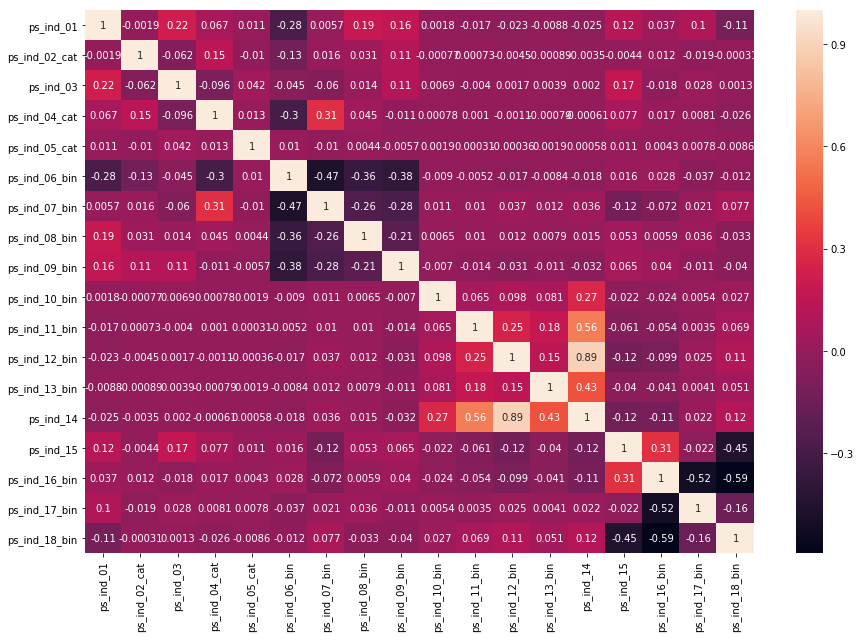

In [42]:
# Now working for correlation in "IND"

ind_col = [w for w in train1.columns if 'ind' in w]

fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(train1[ind_col].corr(), annot= True)

In [43]:
# PS_ind_06_bin and PS_ind_07_bin high correlation - so we drop PS_ind_06_bin
# ps_ind_16_bin corr with ps_ind_17_bin and ps_ind_18_bin so we drop ps_ind_16_bin
train2 = train1.drop(["ps_ind_06_bin", "ps_ind_16_bin"], axis = 1)

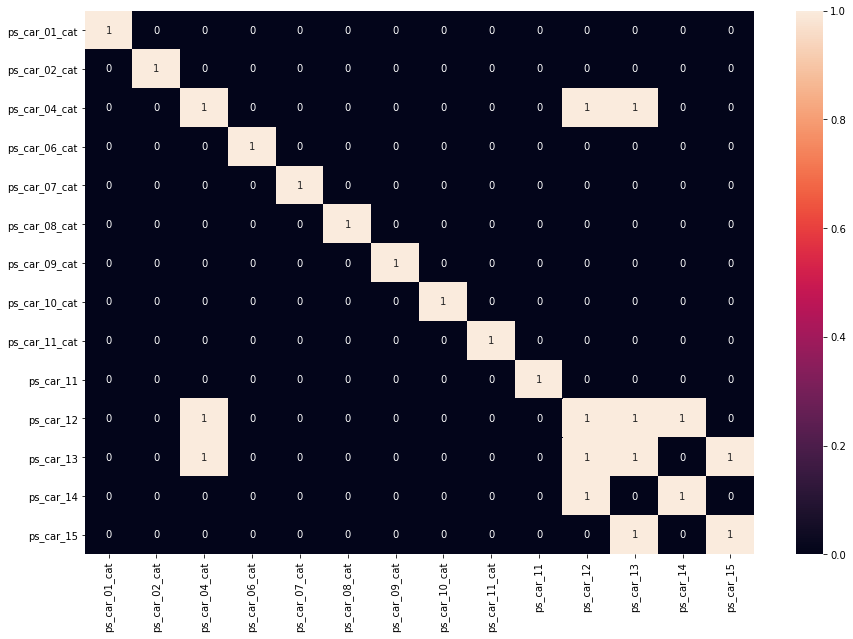

In [44]:
#Checking correlation of 'car' variables
car_col = [w for w in train2.columns if 'car' in w]
fig, ax = plt.subplots(figsize=(15,10))  
sns.heatmap(train2[car_col].corr() > 0.5, annot= True)

In [45]:
#Droping variable 'ps_car_15' as it is highly correlated with the variable 'ps_car_13' and checking the shape of resulting
#dataframe

train3 = train2.drop(["ps_car_15"], axis = 1)

In [46]:
#Removing calculated variables since there correlation with target variable is non significant

column_excluding_calc  = [w for w in train3.columns if "calc" not in w]
train4 = train3[column_excluding_calc]

In [47]:
print(len(train4.columns))
print(train4.columns)

34
Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_17_bin',
       'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat',
       'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat',
       'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14'],
      dtype='object')


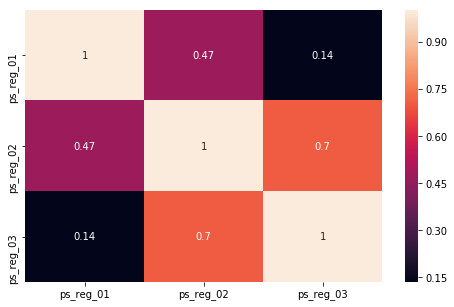

In [48]:
#checking correlation of "REG" variables

reg_col = [w for w in train4.columns if 'reg' in w]
fig, ax = plt.subplots(figsize=(8,5))  
sns.heatmap(train4[reg_col].corr(), annot= True)

#Reg variable seems to somewhat related
#Creating interaction variables for 'reg' variables since they are highly correlated
#Taking sum of ps_reg_01,ps_reg_03 and ps_reg_02 which will be implemented in feature engineering.
#Droping variables 'ps_reg_01 and ps_reg02

In [49]:
print("Number of columns before correlation check: ", train1.shape[1])
print('\nNumber of columns after correlation check: ', train4.shape[1])

Number of columns before correlation check:  57

Number of columns after correlation check:  34


## Outliers

In [50]:
outliers  = detect_outlier(train4.drop(['id', 'target'], axis = 1))

Feature: ps_reg_01, outliers: 0

Feature: ps_reg_02, outliers: 36793

Feature: ps_reg_03, outliers: 35514

Feature: ps_car_12, outliers: 15355

Feature: ps_car_13, outliers: 26913

Feature: ps_car_14, outliers: 30420



In [28]:
#Removing outliers from the dataframe

train5 = train4.drop(train4.index[list(outliers)]).reset_index(drop = True)

print('Number of outliers in more than one feature: {}'.format(len(outliers)))
print('Shape of old data: {}'.format(train4.shape))
print('Shape of new data: {}'.format(train5.shape))

Number of outliers in more than one feature: 39664
Shape of old data: (595212, 34)
Shape of new data: (555548, 34)


## Variance

In [29]:
#Removing low variance variables from the dataframe

#Checking the number of low variance variables in the data using VarianceThreshold from sklearn feature_selection 


selector = VarianceThreshold(threshold=.01)
selector.fit(train5.drop(['id', 'target'], axis=1)) # Fit to train without id and target variables

f = np.vectorize(lambda x : not x) # Function to toggle boolean array elements

v = train5.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('\nThese variables are {}'.format(list(v)))

7 variables have too low variance.

These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_10_cat', 'ps_car_12', 'ps_car_14']


In [30]:
#Dropping the low variance variables from the data and checking the shape of the final dataframe

train6 = train5.drop(list(v), axis = 1)
print('\nShape of df before removal of low variance rows: ',train5.shape)
print('Shape of df after removal of low variance rows: ',train6.shape)


Shape of df before removal of low variance rows:  (555548, 34)
Shape of df after removal of low variance rows:  (555548, 27)


## Feature engineering

In [31]:
#Creating interaction variables for 'reg' variables since they are highly correlated
#Taking sum of reg variable

train6["sum_reg"] = train6["ps_reg_01"] + train6["ps_reg_02"] + train6["ps_reg_03"]

#Droping variables 'ps_reg_01 and ps_reg02

train7 = train6.drop(["ps_reg_01", "ps_reg_02"], axis = 1)

### 5.	Write inferences from data on interval variables. 

•	Variable “ps_reg_03” has 107772 missing values with 18.106490 percentage.

•	We can see some of the variables are highly correlated like - ps_reg_01, ps_reg_02, ps_reg_03

•	“ps_car_12” has very low variance.

•	Features ps_reg_02, ps_reg_03, ps_car_12, ps_car_13, ps_car_14 and ps_car_15 have outliers.

### 6.	Write inferences from data on ordinal variables. 

•	No null values in ordinal variables.

•	Very few are correlated to each other(negligible)

### 7.	Write inferences from data on binary variables. 

•	“ps_ind_10_bin”, “ps_ind_11_bin”, “ps_ind_12_bin”, “ps_ind_13_bin” have very low variance.

•	“ps_ind_06_bin” and “ps_ind_07_bin” are significantly correlated.

### 16. Implement Hot Encoding for categorical features 

In [32]:
#Both One Hot Encoding and GetDummies has the same functionality. 
#One Hot Encoding is resulting in more number of columns so I have used GetDummies.

In [33]:
#Handling Categorical Variables
#Creating dummy variables using get_dummies

#Creating list of categorical variables

cat_feat = MetaData[(MetaData.level == 'categorical') & (MetaData.keep == True)].variable

#Creating dummy variables of categorical variables except variable - ps_car_11_cat as it contains more than 100 categories

v = MetaData[(MetaData.level == 'categorical') & (MetaData.keep)].variable
v = [w for w in list(v) if w!='id' and w!='ps_car_11_cat']

#Printing number of variables before and after dummification

print('Before dummification we have {} variables in train'.format(train7.shape[1]))
train8 = pd.get_dummies(train4, columns=v, drop_first=True)
print('After dummification we have {} variables in train'.format(train8.shape[1]))

Before dummification we have 26 variables in train
After dummification we have 79 variables in train


In [34]:
#Splitting
X_train, X_test, y_train, y_test = train_test_split(train8.drop(['target', 'id'], axis=1),
                                                    train8['target'].astype(int), 
                                                    test_size=0.30, 
                                                    random_state=101)

In [35]:
df_train_temp = X_train
df_train_temp['target'] = y_train

In [36]:
df_train_temp.shape

(416648, 78)

### 9.	What should be the preferred way in this case to balance the data? 

Need to do upscaling/down sampling after train-test split of data to get the desired results

In [37]:
df_sampled = up_and_down_sampling(df_train_temp,20)
X_train_res = df_sampled.drop('target', axis = 1)
y_train_res = df_sampled.target

Target value counts after downsampling: 
 0    333318
1     15181
Name: target, dtype: int64

Target value counts after upsampling: 
 0    333318
1     83329
Name: target, dtype: int64


In [38]:
test_sampled = up_and_down_sampling(df_train_temp,12)

Target value counts after downsampling: 
 0    366650
1     15181
Name: target, dtype: int64

Target value counts after upsampling: 
 0    366650
1     49997
Name: target, dtype: int64


### 10.	How many training records are there after achieving a balance of 12%? 

To obtain a balance between majority and minority class, we used sampling techniques. After sampling there are there are 416648 rows in which 3,66,650 are 0s and 49,997 are 1s

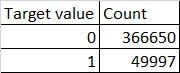

## Feature Scaling

In [39]:
mms = StandardScaler()
X_train_res_scaled = mms.fit_transform(X_train_res)
#y_train_res_scaled = mms.fit_transform(y_train_res)

### 17.	In nominal(categorical) and interval features, which features are suitable for StandardScaler? 

As nominal data cannot be ordered and cannot be measured and nominal data cannot be manipulated using available mathematical operators. Thus, the only measure of central tendency for such type of data is the mode.Hence it is efficient to use Standard Scalar for Interval features.

# Model Building

## Logistic Regression

In [40]:
lm = LogisticRegression()
logistic_model = lm.fit(X_train_res, y_train_res)
predictions_LM = logistic_model.predict(X_test)
print(' Classification Report of Logistic Regression is: \n')
CR_LM = classification_report(y_test,predictions_LM) 
print(CR_LM)

print('Confusion Matrix Logistic Regression is : \n')
print(confusion_matrix(y_test,predictions_LM))

 Classification Report of Logistic Regression is: 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    172051
           1       0.15      0.01      0.02      6513

    accuracy                           0.96    178564
   macro avg       0.56      0.50      0.50    178564
weighted avg       0.93      0.96      0.95    178564

Confusion Matrix Logistic Regression is : 

[[171705    346]
 [  6451     62]]


In [41]:
print(f1_score(y_test,predictions_LM))

0.017916486056928187


### 1.	The Simple Logistic Regression Model seems to have high accuracy. Is that what we need at all? What is the problem with this model?


Simple Logistic Regression Model seems to high accuracy but Logistic regression is a linear model, so it may not work well on non-linear cases. In terms of model complexity, logistic regression has high bias and low variance. So, it might work well if you handle the outliers well but after model deployment, we cannot rely on the predictions because of the high bias and low variance characteristics of Logistic Regression.


### 2.	Why do you think f1-score is 0.0?

The f1 score reaches the best value, meaning perfect precision and recall, at a value of 1. The worst f1 score, which means 
lowest precision and lowest recall, would be a value of 0. However f1 score is not zero in this case.

## Logistic Regression Hyperparameter tuning

In [42]:
max_iterations = [100,200,250]
penalty = ['l1','l2']
C = np.logspace(-2, 2, 10)

In [43]:
parameters = dict(penalty= penalty , C= C, max_iter= max_iterations)
grid_LR = GridSearchCV(estimator = lm , param_grid = parameters)
grid_result = grid_LR.fit(X_train,y_train)
grid_result.best_score_,grid_result.best_params_

(1.0, {'C': 0.01, 'max_iter': 100, 'penalty': 'l2'})

In [45]:
lr_hpt = LogisticRegression(max_iter=100 , penalty = 'l2' , C = 0.01)
logistic_model = lr_hpt.fit(X_train_res, y_train_res)
predictions_LR_HPT = logistic_model.predict(X_test)
print(' Classification Report of Logistic Regression after hyperparameter tuning is: \n')
CR_LR_HPT = classification_report(y_test,predictions_LR_HPT) 
print(CR_LR_HPT)

print('Confusion Matrix Logistic Regression after hyperparameter tuning is : \n')
print(confusion_matrix(y_test,predictions_LR_HPT))
print(f1_score(y_test,predictions_LR_HPT))

 Classification Report of Logistic Regression after hyperparameter tuning is: 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    172051
           1       0.17      0.01      0.01      6513

    accuracy                           0.96    178564
   macro avg       0.56      0.50      0.50    178564
weighted avg       0.93      0.96      0.95    178564

Confusion Matrix Logistic Regression after hyperparameter tuning is : 

[[171834    217]
 [  6470     43]]
0.01269747526945224


## Random Forest

In [46]:
clf_RF = RandomForestClassifier(n_estimators=25, class_weight="balanced")
clf_RF.fit(X_train_res,y_train_res)
predictions_RF = clf_RF.predict(X_test)

print(' Classification Report of RandomForest Classifier is: \n')
CR_RF = classification_report(y_test,predictions_RF) 
print(CR_RF)

print('Confusion matrix of RandomForest Classifier is: \n')
print(confusion_matrix(y_test,predictions_RF))
print(f1_score(y_test,predictions_RF))

 Classification Report of RandomForest Classifier is: 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    172051
           1       0.10      0.00      0.00      6513

    accuracy                           0.96    178564
   macro avg       0.53      0.50      0.49    178564
weighted avg       0.93      0.96      0.95    178564

Confusion matrix of RandomForest Classifier is: 

[[171979     72]
 [  6505      8]]
0.0024268163203397543


### 3.	What is the precision and recall score for the model?

I have opted for Random Forest Classifier. So, the precision and recall score for my model are

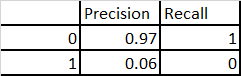

### 4.	What is the most important inference you can draw from the result?

The recall value for 1's class is 0, which implies the algorithm didn't pick any true postives correctly from the dataset.

### 5.	Why do you think f1-score has improved?

f1-score improved from logistic regression to other models because for logistic regression to perform well, the dataset should be lineraly seperable. If the dataset is large, it is very difficult to present the data to the model in a linealy seperable way. There are more complex algorithms such asRandom Forest Classifiers, XGBclassifier which use ensemble modelling for classification. These models outperform Logistic regression because they are implemented using decision tress.

## Linear Support Vector Classifier - (dual = True and max_iter = 500)

In [47]:
clf_LSVC_1 = LinearSVC(dual = True , max_iter = 500)
clf_LSVC_1.fit(X_train_res , y_train_res)
predictions_LSVC_1 = clf_LSVC_1.predict(X_test)

print(' Classification Report of  Linear Support Vector Classifier is: \n')
CR_LSVC_1 = classification_report(y_test,predictions_LSVC_1) 
print(CR_LSVC_1)

print('Confusion Matrix Linear Support Vector Classifier is: \n')
print(confusion_matrix(y_test,predictions_LSVC_1))
print(f1_score(y_test,predictions_LSVC_1))

 Classification Report of  Linear Support Vector Classifier is: 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    172051
           1       0.15      0.00      0.00      6513

    accuracy                           0.96    178564
   macro avg       0.55      0.50      0.49    178564
weighted avg       0.93      0.96      0.95    178564

Confusion Matrix Linear Support Vector Classifier is: 

[[171975     76]
 [  6500     13]]
0.003938200545289306


## Linear Support Vector Classifier - (dual = False and max_iter = 1000)

In [48]:
clf_LSVC_2 = LinearSVC(dual = False , max_iter = 2000)
clf_LSVC_2.fit(X_train_res , y_train_res)
predictions_LSVC_2 = clf_LSVC_2.predict(X_test)

print(' Classification Report of  RandomForest Classifier is: \n')
CR_LSVC_2 = classification_report(y_test,predictions_LSVC_2) 
print(CR_LSVC_2)

print('Confusion Matrix Linear Support Vector Classifier is: \n')
print(confusion_matrix(y_test,predictions_LSVC_2))
print(f1_score(y_test,predictions_LSVC_2))

 Classification Report of  RandomForest Classifier is: 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    172051
           1       0.10      0.00      0.00      6513

    accuracy                           0.96    178564
   macro avg       0.53      0.50      0.49    178564
weighted avg       0.93      0.96      0.95    178564

Confusion Matrix Linear Support Vector Classifier is: 

[[171959     92]
 [  6503     10]]
0.0030234315948601664


### 6.	For model LinearSVC play with parameters – dual, max_iter and see if there is any improvement.

Didn’t find any improvement after tweaking the parameters.

## XGBoost Classifier 

In [49]:
clf_XGB = XGBClassifier()
clf_XGB.fit(X_train_res , y_train_res)
predictions_XGB = clf_XGB.predict(X_test)

print(' Classification Report of  XGBClassifier is: \n')
CR_XGB = classification_report(y_test,predictions_XGB) 
print(CR_XGB)

print('Confusion Matrix XGBClassifier is: \n')
print(confusion_matrix(y_test,predictions_XGB))
print(f1_score(y_test,predictions_XGB))

 Classification Report of  XGBClassifier is: 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98    172051
           1       0.13      0.01      0.01      6513

    accuracy                           0.96    178564
   macro avg       0.55      0.50      0.50    178564
weighted avg       0.93      0.96      0.95    178564

Confusion Matrix XGBClassifier is: 

[[171825    226]
 [  6480     33]]
0.009746012994683993


## SVM with Only 100k records

In [50]:
train8.shape

(595212, 79)

In [51]:
train9 = train8[:100000]
train9.shape

(100000, 79)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(train9.drop(['target', 'id'], axis=1),
                                                    train9['target'].astype(int), 
                                                    test_size=0.30, 
                                                    random_state=101)

In [53]:
df_train_temp = X_train
df_train_temp['target'] = y_train

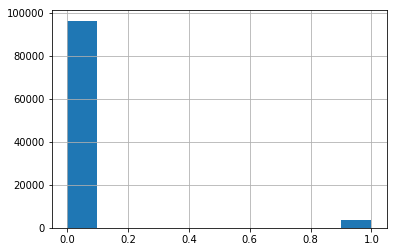

In [54]:
train9['target'].hist()

In [63]:
#upsampling and downsampling
df_upsampled_SVM = up_and_down_sampling(train9,20)
X_train_res_SVM = df_upsampled_SVM.drop(['target','id'], axis = 1)
y_train_res_SVM = df_upsampled_SVM.target

Target value counts after downsampling: 
 0    80000
1     3671
Name: target, dtype: int64

Target value counts after upsampling: 
 0    80000
1    20000
Name: target, dtype: int64


In [64]:
X_train_res_SVM.shape

(100000, 77)

In [65]:
X_test.shape

(30000, 77)

In [66]:
clf_SVC = svm.SVC()
clf_SVC.fit(X_train_res_SVM , y_train_res_SVM)
predictions_SVC = clf_SVC.predict(X_test)

print(' Classification Report of  SVC with only 100k records is: \n')
CR_XGB = classification_report(y_test,predictions_SVC) 
print(CR_XGB)

print('Confusion Matrix SVC with only 100k records is: \n')
print(confusion_matrix(y_test,predictions_SVC))
print(f1_score(y_test,predictions_SVC))

 Classification Report of  SVC with only 100k records is: 

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     28903
           1       0.00      0.00      0.00      1097

    accuracy                           0.96     30000
   macro avg       0.48      0.50      0.49     30000
weighted avg       0.93      0.96      0.95     30000

Confusion Matrix SVC with only 100k records is: 

[[28903     0]
 [ 1097     0]]
0.0


### 7.	SVC with Imbalance Check & Feature Optimization & only 100K Records → is there improvement in scores?

The precision and recall scores for the target value ‘1’ became zero which implies the recall of the model is not good. This might be because of the huge difference between the number of 0’s and 1’s in the target column.

### 8. XGBoost is one the better classifiers -- but still f1-score is very low. What could be the reason? 

F1-score is not low for my model. Instead Gradient Boosting gives low f1-scores 

•	Overfitting 

•	Improper Hyperparameter tuning

Gradient Boosting trees build one tree at a time and each newly added tree helps to correct errors made by previously trained tree. There are typically three parameters – number of trees, depth of tree and learning rate. Gradient boosting trees are more prone to overfitting since it requires a lot of hyperparameter tuning.


### 9.	What is the increase in number of features after one-hot encoding of the data?

The number of features increased from 57 to 102. So, the increase is 45.

### 10.	Is there any improvement in scores after encoding?

Yes, There was significant improvement after encoding.

### 11.	If not missing a positive sample is the priority which model is best so far? 

The model with the highest true positive score can be used. In this case, Linear Vector Classifier with hyperparameters dual = False and max_iter = 1000 should be used.

### 12.	If not marking negative sample as positive is top priority, which model is best so far? 

The model with the lowest false postives should be used. In this case, Linear Support Vector Classifier with hyperparameters
(dual = True and max_iter = 500) should be used.

### 13.	Do you think using AdaBoost can give any significant improvement over XGBoost? 

There will be a significant improvement but XG boost performs better than Adaboost in most of the cases as it can handle large amounts of data.

## Multi Layer Perceptron Classifier

In [67]:
#Training the MLP classifier with only 100k records since training the model with full dataset requires high computational power
clf_MLP = MLPClassifier()

In [68]:
hidden_layer_sizes = [[20] , [40,20] , [40,20,10]]
activation = ['logistic' , 'relu']
param_grid = dict(hidden_layer_sizes = hidden_layer_sizes , activation  = activation , batch_size = [10000,15000])
grid = GridSearchCV(estimator = clf_MLP , param_grid = param_grid)

In [80]:
grid_result = grid.fit(X_train,y_train)

In [81]:
grid_result.best_score_,grid_result.best_params_

(0.9632285714285714,
 {'activation': 'logistic', 'batch_size': 10000, 'hidden_layer_sizes': [20]})

In [86]:
y_pred_MLP = grid_result.predict(X_test)

In [87]:
CR_MLP = classification_report(y_test,predictions_SVC) 
print(CR_MLP)

print(confusion_matrix(y_test,y_pred_MLP))
print(f1_score(y_test,y_pred_MLP))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     28903
           1       0.00      0.00      0.00      1097

    accuracy                           0.96     30000
   macro avg       0.48      0.50      0.49     30000
weighted avg       0.93      0.96      0.95     30000

[[28903     0]
 [ 1097     0]]
0.0


In [93]:
clf_MLP1 = MLPClassifier(hidden_layer_sizes=[20], batch_size=10000, activation= 'logistic', random_state=42)

In [94]:
clf_MLP1.fit(X_train,y_train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size=10000, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[20], learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [95]:
y_pred_MLP1 = clf_MLP1.predict(X_test)

In [97]:
X_test.columns

Index(['ps_ind_01', 'ps_ind_03', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15', 'ps_ind_17_bin',
       'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11_cat',
       'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_ind_02_cat_2',
       'ps_ind_02_cat_3', 'ps_ind_02_cat_4', 'ps_ind_04_cat_1',
       'ps_ind_05_cat_1', 'ps_ind_05_cat_2', 'ps_ind_05_cat_3',
       'ps_ind_05_cat_4', 'ps_ind_05_cat_5', 'ps_ind_05_cat_6',
       'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_01_cat_3',
       'ps_car_01_cat_4', 'ps_car_01_cat_5', 'ps_car_01_cat_6',
       'ps_car_01_cat_7', 'ps_car_01_cat_8', 'ps_car_01_cat_9',
       'ps_car_01_cat_10', 'ps_car_01_cat_11', 'ps_car_02_cat_1',
       'ps_car_04_cat_1', 'ps_car_04_cat_2', 'ps_car_04_cat_3',
       'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6',
       'ps_car_04_cat_7', 'ps_car_04_cat_8', 'ps_car_04

In [96]:
CR_MLP1 = classification_report(y_test,y_pred_MLP1) 
print(CR_MLP1)

print(confusion_matrix(y_test,y_pred_MLP1))
print(f1_score(y_test,y_pred_MLP1))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     28903
           1       0.00      0.00      0.00      1097

    accuracy                           0.96     30000
   macro avg       0.48      0.50      0.49     30000
weighted avg       0.93      0.96      0.95     30000

[[28903     0]
 [ 1097     0]]
0.0


### 14.	MLPClassifier is the neural network we are trying. But how to choose the right no. of layers and size? 

We can use GridSearchCV, RandomizedSearchCV ,etc.. to find the best parameters for the MLP classifier. But if the dataset is large, it takes a lot of time (if you have less computational power) to get the best parameters.

### 15.	At what layer size we get the best f1-score?

At one hidden layer with a size of 20 neurons , I got the best f1 score.